## PanSTARRS $(g-z)$ analysis steps recreated in this notebook:

Retrieve a standard 3000 pixel frame with the galaxy at the center in g and z. Get the exposure time from the header. Get the extinction values from NED.

To get the background subtraction right, mask off the main galaxy and look at the residual well away from the galaxy (much larger FOV than WFC3/IR).

Run SExtractor to identify stars and other objects, and make a mask automatically. elliprof is used to remove the galaxy prior to running SExtractor.

You still have to edit those masks manually because PS images typically have lines and edges crossing the brighter galaxies and I don’t want weird color discontinuities. This is the only manual step--editing the masks to take out lines.

Generate the $(g-z)$ color map by subtracting sky, dividing by exposure time, calculating $-2.5\log f$, correcting for extinction, and subtracting to get $(g-z)$.

The last step is to use monsta “fluc mask” command to make the elliptical annuli in the same sizes as the SBF analysis and write the median and average values to a text file.

## Installing Required Python Packages

Note: run the following cell once. 

In [17]:
import sys, os

# path of the pysbf folder
# sys.path.insert(0, os.getcwd()+"/../../")

pysbf_path = "/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/"

sys.path.insert(0, pysbf_path)
from pysbf import *

configFolder = pysbf_path + "pysbf/config/sextractor/"

In [18]:
configFolder = pysbf_path + "pysbf/config/sextractor/"

## Object Initialization

In [39]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program
galaxy_root = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
PS_root = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/'

In [40]:
# name = "c328014"
## name = "c539126"
# name = "c540079"
## name = "e436045"
# name = "e461007"
## name = "e462015"
## name = "e507025"
## name = "ic5193"
# name = "n0080"
## name = "n0380"
# name = "n0679"
## name = "n0750"
## name = "n2208"
# name = "n2256"
# name = "n2329"
## name = "n2418"
## name = "n2569"
# name = "n3070"
## name = "n3091"
## name = "n3308"
## name = "n3311"
## name = "n4825"
## name = "n4955"
## name = "n6223"
## name = "n6577"
## name = "n6688"
## name = "n6968"
## name = "n7265"
# name = "n7274"
## name = "n7426"
## name = "n7618"
## name = "p158229"
## name = "p170207"
## name = "u03353"
## name = "u03396"
# name = "u11990"
name = "u12517"

# This is the radial region to fit with elliprof.
# Values around 80 are good for small galaxies, 100 for larger ones.
NR = str(80)


HST file:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/u12517/u12517j.fits
PS files:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/u12517g.fits    /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/u12517z.fits
RA [deg]:  349.9766666667
Dec [deg]:  43.95766666667


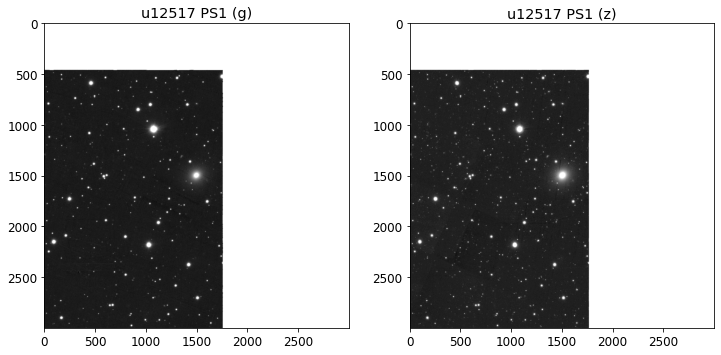

In [41]:
outFolder = PS_root + name + '/PS_Outputs_' + name + '/'
createDir(outFolder)
#full_name = galaxy_root + name
j_fits = galaxy_root + name + '/' + name + 'j.fits'
g_fits = PS_root + name + '/' + name + 'g.fits'
z_fits = PS_root + name + '/' + name + 'z.fits'
PS_mask = PS_root + name + '/' + name + '.mask'
PS_skymask = PS_root + 'pssky.mask'
print("HST file: ", j_fits)
print("PS files: ", g_fits, '  ', z_fits)

hdul = fits.open(j_fits)
hdr = hdul[0].header     # header

ra  = hdr["RA_TARG"]
dec = hdr["DEC_TARG"]

print("RA [deg]: ",  ra)
print("Dec [deg]: ", dec)

size = 3000   # size in pixels (0.25 arcsec/pixel)

gim = getgrayim(ra,dec,size=size,filter="g")
zim = getgrayim(ra,dec,size=size,filter="z")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))

pylab.subplot(121)
pylab.imshow(gim,origin="upper", cmap='gray')
pylab.title(name + ' PS1 (g)')

pylab.subplot(122)
pylab.title(name + ' PS1 (z)')
pylab.imshow(zim,origin="upper", cmap='gray')

### Looking up NED for Galaxtic Extinctions

Here, all we need is to have the coordinates of the galaxy

In [42]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

PS1_rows = [band for band in df_extinction.index.values if "PS1" in band]

df_extinction.loc[PS1_rows]

,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
PS1 g,0.49,0.592,2011ApJ...737..103S
PS1 r,0.62,0.424,2011ApJ...737..103S
PS1 i,0.75,0.314,2011ApJ...737..103S
PS1 z,0.87,0.247,2011ApJ...737..103S
PS1 y,0.97,0.203,2011ApJ...737..103S
PS1 w,0.62,0.437,2011ApJ...737..103S


In [43]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["PS1 g"]
zext = extinctions["PS1 z"]

print("Galactic Extinction (PS1 g): ", gext)
print("Galactic Extinction (PS1 z): ", zext)

Galactic Extinction (PS1 g):  0.592
Galactic Extinction (PS1 z):  0.247


### Downloading PS1 files if they don't already exist

In [44]:
## downloading PS1 fits files 
def download_PS1(ra, dec, size, filter='g', format='fits', outFits="PS1.fits"):

    fitsurl = geturl(ra, dec, size=int(size), filters=filter, format=format)
    xcmd("curl '"+fitsurl[0]+"' -o "+outFits, verbose=False)
    print('Downloaded ... ' + outFits)

In [45]:
# if the original PS1 files do not exist, download them directly and use them
if not os.path.exists(g_fits):
    print('Could not find '+g_fits+'\n Downloading ...')
    g_fits = outFolder+"/"+name+"_g.fits"
    download_PS1(ra, dec, size, filter='g', outFits=g_fits)
if not os.path.exists(z_fits):
    print('Could not find '+z_fits+'\n Downloading ...')
    z_fits = outFolder+"/"+name+"_z.fits"
    download_PS1(ra, dec, size, filter='z', outFits=z_fits)

print("g-band fits file: " + g_fits)
print("z-band fits file: " + z_fits)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header
gexp = hdr["EXPTIME"]

hdul = fits.open(z_fits)
hdr = hdul[0].header     # header
zexp = hdr["EXPTIME"]

print("g-band exposure time (sec): " + str(gexp))
print("z-band exposure time (sec): " + str(zexp))

Could not find /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/u12517g.fits
Downloaded ... /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/PS_Outputs_u12517//u12517_g.fits
Could not find /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/u12517z.fits
Downloaded ... /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/PS_Outputs_u12517//u12517_z.fits
g-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/PS_Outputs_u12517//u12517_g.fits
z-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/PS/u12517/PS_Outputs_u12517//u12517_z.fits
g-band exposure time (sec): 602.0
z-band exposure time (sec): 480.0


## Mask and residual image section

This next block is for making PanSTARRS masks using Source Extractor.
But these masks are always insufficient because they do not take out the stripes and defects.
They should be manually edited. Please edit the mask and rerun.

In [29]:
# create residual images for Source Extractor
monsta_script = """
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    set nr="""+NR+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    elliprof 3 model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    elliprof 4 model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '"""+outFolder+name+"""g.resid'
    wd 6 '"""+outFolder+name+"""z.resid'
    box 1 nc=700 nr=700 cc=1500 cr=1500
    wind 5 box=1
    wind 6 box=1
    wd 5 '"""+outFolder+name+"""g.zoom.resid'
    wd 6 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


'OK'

In [30]:
# Run Source Extractor if needed to generate the mask.
monsta_script = """
    rd 5 '"""+outFolder+name+"""g.resid'
    rd 6 '"""+outFolder+name+"""z.resid'
    rd 7 '"""+outFolder+"""/psg.obj'
    rd 8 '"""+outFolder+"""/psz.obj'
    di 7 7
    di 8 8
    mi 8 7
    wd 8 '"""+outFolder+name+""".mask' bitmap

"""
sestring_g = outFolder+name+'z.resid -c '+configFolder+'psg.inpar -CATALOG_NAME '+outFolder+'psg.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psg.obj'
sestring_z = outFolder+name+'g.resid -c '+configFolder+'psz.inpar -CATALOG_NAME '+outFolder+'psz.cat -PARAMETERS_NAME '+configFolder+'sbf.param -FILTER_NAME '+configFolder+'gauss_2.0_5x5.conv -STARNNW_NAME '+configFolder+'default.nnw -CHECKIMAGE_NAME '+outFolder+'psg.obj'
# print(sestring_g)
# print(sestring_z)

if not os.path.exists(PS_mask):
    print('Could not find '+PS_mask)
    PS_mask = outFolder + name + '.mask'
    print('Making ' + PS_mask + ' now. Please edit it before proceeding.')
    ! sex {sestring_g}
    ! sex {sestring_z}
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psg.inpar -CATALOG_NAME """+outFolder+"""/psg.cat -CHECKIMAGE_NAME """+outFolder+"""/psg.obj
#    % sex """+outFolder+name+"""g.resid -c """+configFolder+"""psz.inpar -CATALOG_NAME """+outFolder+"""/psz.cat -CHECKIMAGE_NAME """+outFolder+"""/psz.obj
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


Could not find /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask
Making /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask now. Please edit it before proceeding.
> 
----- SExtractor 2.8.6 started on 2022-12-02 at 13:15:37 with 8 threads

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for c328014z.resid
Measuring from: "Unnamed"  / 3000 x 3000 / 0 bits FLOATING POINT data
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   40
> Setting up background map at line:   80
> Setting up background map at line:  120
> Setting up background map at line:  160
> Setting up background map at line:  200
> Setting up background map at line:  240
> Setting up background map at line:  280
> Setting up background map at line:  32

> Line:  864  Objects:      456 detected /        0 sextracted
> Line:  880  Objects:      466 detected /        0 sextracted
> Line:  896  Objects:      474 detected /        0 sextracted
> Line:  912  Objects:      482 detected /        0 sextracted
> Line:  928  Objects:      489 detected /        0 sextracted
> Line:  944  Objects:      491 detected /        0 sextracted
> Line:  960  Objects:      504 detected /        0 sextracted
> Line:  976  Objects:      520 detected /        0 sextracted
> Line:  992  Objects:      526 detected /        0 sextracted
> Line: 1008  Objects:      529 detected /        0 sextracted
> Line: 1024  Objects:      538 detected /        0 sextracted
> Line: 1040  Objects:      546 detected /        0 sextracted
> Line: 1056  Objects:      556 detected /        0 sextracted
> Line: 1072  Objects:      564 detected /        0 sextracted
> Line: 1088  Objects:      569 detected /        0 sextracted
> Line: 1104  Objects:      576 detected /        0 sex

> Line: 2944  Objects:     1556 detected /        0 sextracted
> Line: 2960  Objects:     1565 detected /        0 sextracted
> Line: 2976  Objects:     1569 detected /        0 sextracted
> Line: 2992  Objects:     1577 detected /        0 sextracted
Objects: detected 1591     / sextracted 1503                   
> Closing files
> 
> All done (in 1 s)
> 
----- SExtractor 2.8.6 started on 2022-12-02 at 13:15:38 with 8 threads

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for c328014g.resid
Measuring from: "Unnamed"  / 3000 x 3000 / 0 bits FLOATING POINT data
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   40
> Setting up background map at line:   80
> Setting up background map at line:  120
> Setting up background map at line:  160
> Setting up background map at line:  200
> Setting up background map at

> Line: 1072  Objects:      290 detected /        0 sextracted
> Line: 1088  Objects:      294 detected /        0 sextracted
> Line: 1104  Objects:      299 detected /        0 sextracted
> Line: 1120  Objects:      301 detected /        0 sextracted
> Line: 1136  Objects:      305 detected /        0 sextracted
> Line: 1152  Objects:      309 detected /        0 sextracted
> Line: 1168  Objects:      313 detected /        0 sextracted
> Line: 1184  Objects:      317 detected /        0 sextracted
> Line: 1200  Objects:      324 detected /        0 sextracted
> Line: 1216  Objects:      330 detected /        0 sextracted
> Line: 1232  Objects:      332 detected /        0 sextracted
> Line: 1248  Objects:      342 detected /        0 sextracted
> Line: 1264  Objects:      345 detected /        0 sextracted
> Line: 1280  Objects:      353 detected /        0 sextracted
> Line: 1296  Objects:      361 detected /        0 sextracted
> Line: 1312  Objects:      366 detected /        0 sex

> Line: 2960  Objects:      904 detected /        0 sextracted
> Line: 2976  Objects:      912 detected /        0 sextracted
> Line: 2992  Objects:      922 detected /        0 sextracted
Objects: detected 928      / sextracted 829                    
> Closing files
> 
> All done (in 1 s)
===== MONSTA =====
   1
   2    rd 5 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014g.resid'
   3    rd 6 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014z.resid'
   4    rd 7 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014//psg.obj'
   5    rd 8 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014//psz.obj'
   6    di 7 7
   7    di 8 8
   8    mi 8 7
   9    wd 8 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask' bitmap
  10
  11
 Can't open file /media/Data/Home/PanStarrs/Jan/HI/

In [31]:
# Multiply residual images by mask for display
monsta_script = """
    rd 1 '"""+outFolder+name+"""g.resid'
    rd 2 '"""+outFolder+name+"""z.resid'
    rd 10 '"""+PS_mask+"""' bitmap ! just in case there is one
    mi 1 10
    mi 2 10
    wd 1 '"""+outFolder+name+"""g.resid'
    wd 2 '"""+outFolder+name+"""z.resid'
    box 1 nc=500 nr=500 cc=1500 cr=1500
    wind 1 box=1
    wind 2 box=1
    wd 1 '"""+outFolder+name+"""g.zoom.resid'
    wd 2 '"""+outFolder+name+"""z.zoom.resid'
"""
run_monsta(monsta_script, 'monsta.pro', 'monsta.log')


===== MONSTA =====
   1
   2    rd 1 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014g.resid'
   3    rd 2 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014z.resid'
   4    rd 10 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask' bitmap ! just in case there is one
   5    mi 1 10
   6    mi 2 10
   7    wd 1 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014g.resid'
   8    wd 2 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014z.resid'
   9    box 1 nc=500 nr=500 cc=1500 cr=1500
  10    wind 1 box=1
  11    wind 2 box=1
  12    wd 1 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014g.zoom.resid'
  13    wd 2 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014z.zoom.re

" Can't open FITS file/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask\n Error at line   4:      rd 10 '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/PS/c328014/PS_Outputs_c328014/c328014.mask' bitmap ! just in case there is one\n Subroutine stack   Line number:\n VISTA                                                 0\n ./monsta.pro                                          4\n >> "

In [12]:
# Source Extractor test cell - this seems to work now.
# ! sex {sestring_g}

Text(0.5, 1.0, 'Sky Mask')

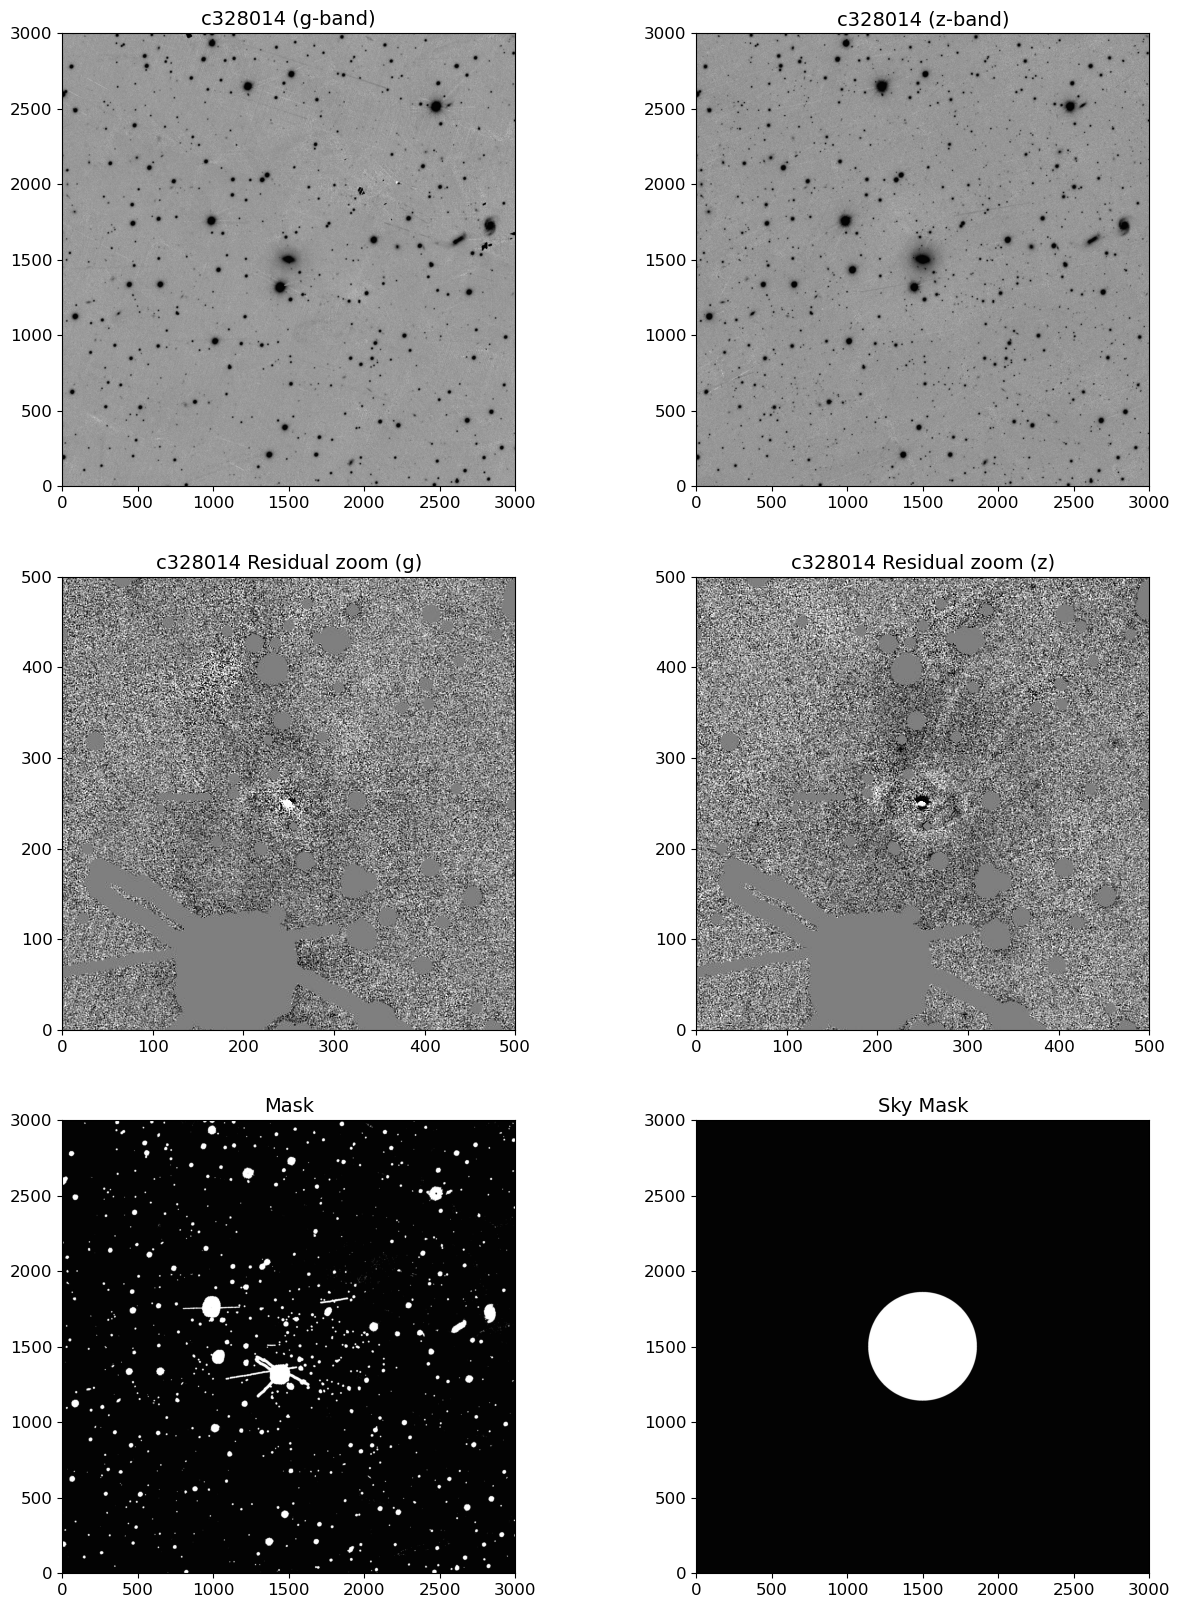

In [13]:
#PS_newmask = outFolder+name+".mask"

plt.figure(figsize=(15,20))

plt.subplot(321)
ax = plt.gca()
tv(g_fits,ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)

plt.subplot(322)
ax = plt.gca()
tv(z_fits,ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)

plt.subplot(325)
ax = plt.gca()
tv(PS_mask,ax=ax)
ax.set_title("Mask", fontsize=14)

plt.subplot(323)
ax = plt.gca()
tv(outFolder+name+"g.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (g)", fontsize=14)

plt.subplot(324)
ax = plt.gca()
tv(outFolder+name+"z.zoom.resid",ax=ax, options='')
ax.set_title(name + " Residual zoom (z)", fontsize=14)

plt.subplot(326)
ax = plt.gca()
tv(PS_skymask,ax=ax)
ax.set_title("Sky Mask", fontsize=14)


## Measure $(g-z)$

Unity = 0.012     Average radius =    24.7
Unity = 0.011     Average radius =    24.3
Unity = 0.023     Average radius =    46.7
Unity = 0.030     Average radius =    92.4
Unity = 0.014     Average radius =   194.9
Unity = 0.008     Average radius =   188.1
Unity = 0.014     Average radius =   191.3
Unity = 0.012     Average radius =   191.7
    
 SKYG    =  -1.5812802594155073E-003
 SKYZ    =  -6.2416973523795605E-003
    
 c328014 average (g-z) extinction corrected
    
 AVC0    =   1.4050710201263428     
 AVC1    =   1.4026265144348145     
 AVC2    =   1.3960033655166626     
 AVC5    =   1.4185949862003326     


Text(0.5, 1.0, 'c328014 (g-z) color map')

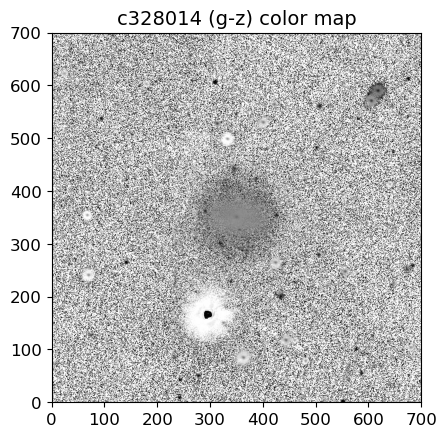

In [14]:
monsta_script = """
    string name '"""+name+"""'

    ! make the g-z color map
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    dc 1 """+str(gexp)+"""
    dc 2 """+str(zexp)+"""
    cop 3 1
    cop 4 2
    rd 5 '"""+PS_skymask+"""'
    ! read the input PS mask; if it's not there, read the one that the notebook just made.
    rd 6 '"""+PS_mask+"""'
    mi 5 6
    mi 3 5
    mi 4 5
    cop 10 4
    ! sky values
    abx 3 all median median=skyg silent
    abx 4 all median median=skyz silent
    sc 1 skyg
    sc 2 skyz
    log 1
    mc 1 -2.5
    sc 1 """+str(gext)+"""
    log 2
    mc 2 -2.5
    sc 2 """+str(zext)+"""
    cop 3 1
    si 3 2
    wd 3 '"""+outFolder+name+"""gz.clr'
    cop 10 3
    box 1 nc=700 nr=700 cc=1500 cr=1500
    wind 10 box=1
    wd 10 '"""+outFolder+name+"""gz.zoom.clr'

    ! measure the (g-z) values
    cop 1 3
    mi 1 6
    close 6
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    abx 2 all median=median medrms=rms silent
    ! typ median,rms
    set max=2*rms+median
    set min=-2*rms+median
    ! typ min,max
    clip 1 max=max vmax=0 min=min vmin=0
    close 2
    ! open 2 nr=512 nc=512
    ! fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=127 a0=0 a1=360 ! cc
    open 3 nr=512 nc=512
    fluc 3 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    open 4 nr=512 nc=512
    fluc 4 1 mask x0=1500 y0=1500 r0=31.8 r1=63.5 a0=0 a1=360 ! c1
    open 5 nr=512 nc=512
    fluc 5 1 mask x0=1500 y0=1500 r0=63.5 r1=127 a0=0 a1=360 ! c2
    open 6 nr=512 nc=512
    fluc 6 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=0 a1=90 ! nw
    open 7 nr=512 nc=512
    fluc 7 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=90 a1=180 ! sw
    open 8 nr=512 nc=512
    fluc 8 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=180 a1=270 ! se
    open 9 nr=512 nc=512
    fluc 9 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=270 a1=360 ! ne

    ! medians
    ! abx 2 all median median=medcc medrms=medccrms silent
    abx 3 all median median=medc0 medrms=medc0rms silent
    abx 4 all median median=medc1 medrms=medc1rms silent
    abx 5 all median median=medc2 medrms=medc2rms silent
    abx 6 all median median=mednw medrms=mednwrms silent
    abx 7 all median median=medsw medrms=medswrms silent
    abx 8 all median median=medse medrms=medserms silent
    abx 9 all median median=medne medrms=mednerms silent

    ! do in the same regions as we do SBF measurements
    set medc5=mednw+medsw+medse+medne/4
    printf ' '
    typ skyg,skyz
    ! printf ' '
    ! printf '{name} median (g-z) extinction corrected'
    ! printf ' '
    ! typ medc0,medc1,medc2,medc5
    ! printf '{name} (g-z) rms values'
    ! typ medc0rms,medc1rms,medc2rms,mednerms

    ! averages
    ! abx 2 all mean=avcc rms=avccrms silent
    abx 3 all mean=avc0 rms=avc0rms silent
    abx 4 all mean=avc1 rms=avc1rms silent
    abx 5 all mean=avc2 rms=avc2rms silent
    abx 6 all mean=avnw rms=avnwrms silent
    abx 7 all mean=avsw rms=avswrms silent
    abx 8 all mean=avse rms=avserms silent
    abx 9 all mean=avne rms=avnerms silent
    set avc5=avnw+avsw+avse+avne/4
    printf ' '
    printf '{name} average (g-z) extinction corrected'
    printf ' '
    typ avc0,avc1,avc2,avc5
    ! printf '{name} (g-z) rms values' 
    ! typ avc0rms,avc1rms,avc2rms,avnerms

"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
!cat monsta.log

ax = plt.gca()
tv(outFolder+name+"gz.zoom.clr",ax=ax, options='0 3')
ax.set_title(name + " (g-z) color map", fontsize=14)
